# CarND Advanced Lane Lines

The code used in the project and the final annotated video can be found [here](https://github.com/itoyjakra/Udacity_CarND/tree/master/Term1/Project4). The files Frame.py and Lane.py define the Frame and Lane classes respectively. The class LaneSeries is defined in LaneSeries.py, which handles a series of frames. The file DetectLane.py has the pipeline for lane detection.

## 1. Camera Calibration

The camera calibration is performed in the 'CalibrateCamera' procedure in DetectLane.py. It uses the provided chessboard patterns to detect the corners of the chessboard first. The detected corners used in conjunction of a regular square greed with the same number of vertices is used to remove the camera distortion. Here's an example: 

In [4]:
from DetectLane import CalibrateCamera
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

mtx, dist = CalibrateCamera()

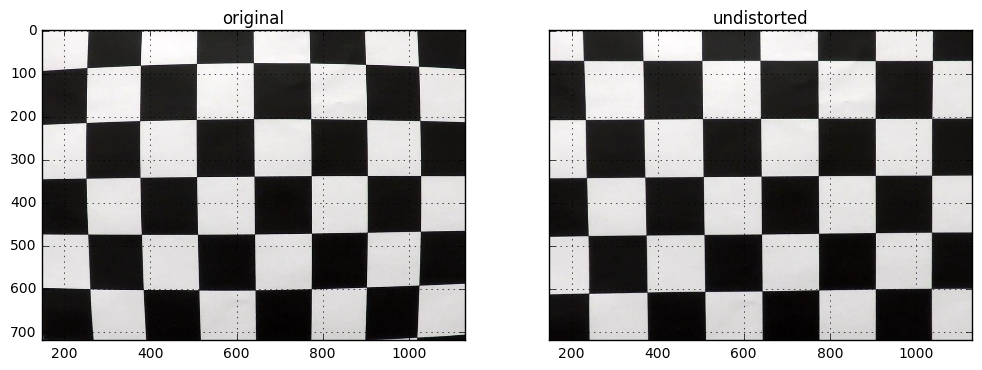

In [2]:
f = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(f, mtx, dist, None, mtx)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4], sharey=True)
ax1.imshow(f)
ax1.grid()
ax1.set_title("original")
ax2.imshow(undist)
ax2.grid()
ax2.set_title("undistorted")

## 2. Pipeline

### 2a. Correct image distortion 

The pipeline to process a single frame of image starts by correcting for camera distortion using the transformation learnt earlier.

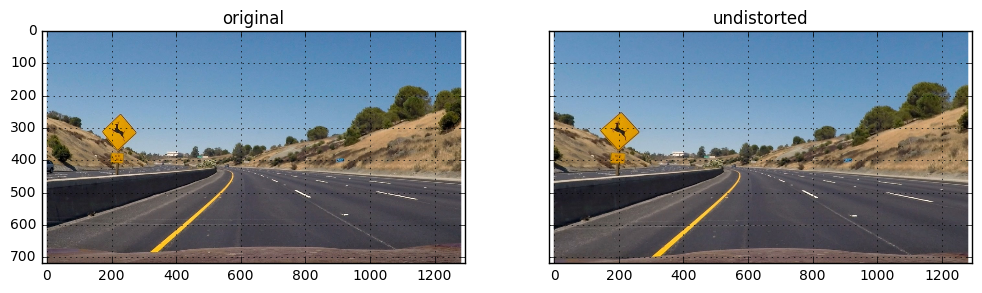

In [4]:
im_jpg = mpimg.imread('test_images/test2.jpg')
undist_img = cv2.undistort(im_jpg, mtx, dist, None, mtx)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 3], sharey=True)
ax1.imshow(im_jpg)
ax1.grid()
ax1.set_title("original")
ax2.imshow(undist_img)
ax2.grid()
ax2.set_title("undistorted")

### 2b. Apply Filters

The undistorted image is then processed through a combination of color and gradient filters to obtain a binary image. This is the step where a lot of trial and error is involved. The final combination used the red channel of the RGB filter and a combination of the x component, direction and magnitude  of the Sobel gradient. The implementation can be found in the 'process' member procedure of the Frame class. Here's an example of the binary image obtained for some test images:

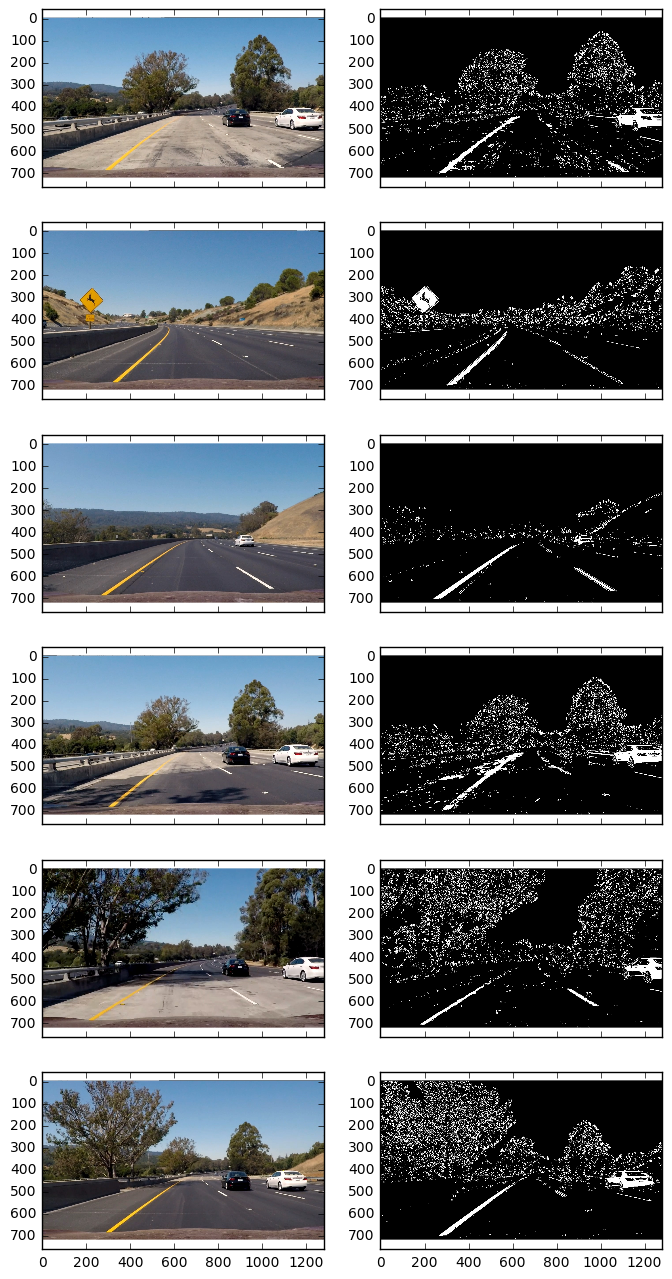

In [9]:
from Frame import Frame
import _pickle as pickle
import glob
with open('params.pkl', 'rb') as fid:
    mtx, dist, dst, src, M, Minv = pickle.load(fid)
files = glob.glob('test_images/test*.jpg')
L = len(files)
fig, ax = plt.subplots(L, 2, sharex=True, figsize=[8, 16])

for i, f in enumerate(files):
    f = mpimg.imread(f)
    undist = cv2.undistort(f, mtx, dist, None, mtx)
    im = Frame(undist)
    war, ch = im.process(M)
    ax[i][0].imshow(f)
    ax[i][1].imshow(ch, cmap='gray')

### 2c. Perspective Transform

For lane detection, the binany image is undergone through a perspective transform. The actual transformation matrix is obtained by choosing an image with straight lanes as the source image and casting them onto a destination image where they appear as a pair of 'parallel' straight lines. The source and destination points are hard coded and the transformation is performed in the procedure PerspectiveTransform() under DetectLane.py. Here's how the original lanes appear after the perspective transform:

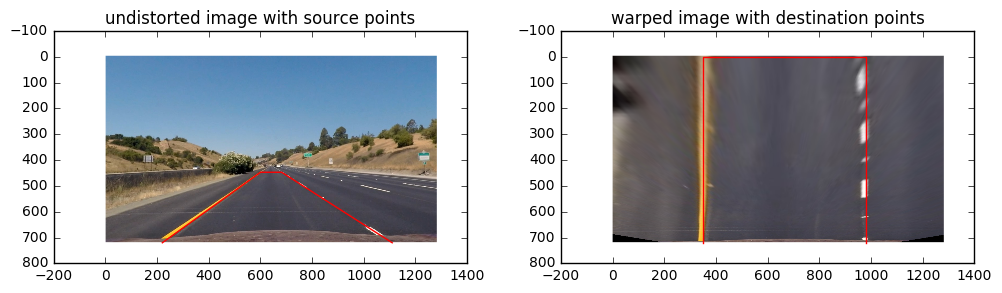

In [23]:
mtx, dist = CalibrateCamera()
img = mpimg.imread("test_images/straight_lines1.jpg")

undist = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
offset = 100
img_size = (gray.shape[1], gray.shape[0])
src = np.float32([(275, 680),  (600, 447), (682, 447), (1040, 680)])
src = np.float32([(220, 720),  (600, 447), (682, 447), (1110, 720)])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
dst = np.float32([[350, img_size[1]], [350, 0], [980, 0], [980, img_size[1]]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, img_size)
Minv = cv2.getPerspectiveTransform(dst, src)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 3])
ax1.imshow(undist)
ax1.plot(src[:,0], src[:,1], '-r')
ax1.set_title("undistorted image with source points")
ax2.imshow(warped)
ax2.plot(dst[:,0], dst[:,1], '-r')
ax2.set_title("warped image with destination points")

Using the perspective transform matrix, the binany image obtained in the last step is transformed as follows:

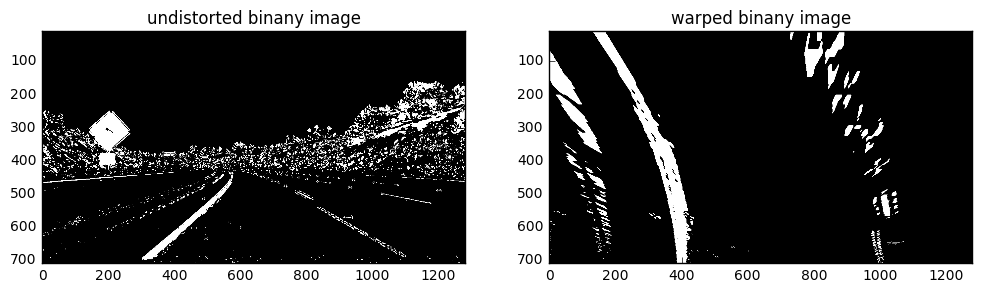

In [22]:
img_size = (im.image.shape[1], im.image.shape[0])
warped_img = cv2.warpPerspective(ch, M, img_size)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=[12, 3])
ax1.imshow(ch, cmap='gray')
ax1.set_title("undistorted binany image")
ax2.imshow(warped_img, cmap='gray')
ax2.set_title("warped binany image")

### 2d. Lane detection

The lane detection process consists of two parts.

* The warped image is broken down into several (9 in my case) horizontal strips. The location of the left and right lane centers in each of these strips are detected by looking at the peak of the signal obtained by convolving the strip with a rectangular window.

* For each of the left and right lanes, a second degree polynomial is fitted through the strip peak locations obtained before.

The figure below shows an example of the center of the left and right lanes obtained through convolving a window, represented by the green box, for each strip in the image. The corresponding best fitted polynomial lines are also depicted.

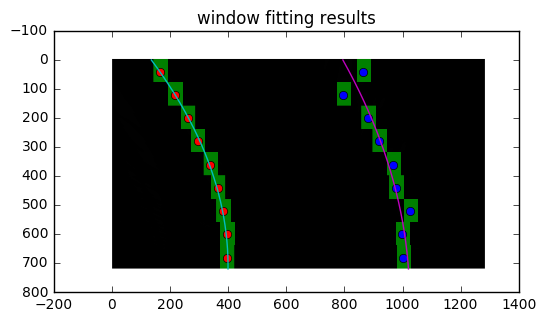

In [14]:
from Lane import Lane

window_width = 50
window_height = 80
margin = 100

window_params = (window_width, window_height, margin)
lane = Lane(undist_img, warped_img, window_params)
cents = lane.find_window_centroids()
lane.display_lane_centers(cents)

### 2e. Radius of Curvature calculation and final lane rendering

The radii of curvatue for each of the lane lines is calculated in the radius_of_curvature() procedure of the Lane class.

Finally the area between the fitted lines is highlighted to show the detected lane area. It is implemented in the  plot_lane() procedure of Lane class.

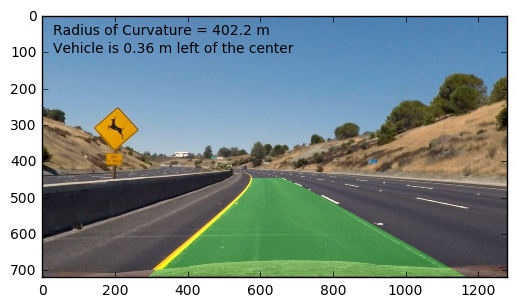

In [25]:
roc, offset = lane.radius_of_curvature(cents)
fin_img, roc, offset = lane.plot_lane(Minv, (roc, offset), window_centroids=cents)
plt.imshow(fin_img)

if offset > 0:
    side = 'right'
else:
    side = 'left'
plt.text(30, 50, "Radius of Curvature = %.1f m" % roc)
plt.text(30, 100, "Vehicle is %.2f m %s of the center" % (np.abs(offset), side))

## 3. Video rendering

Each frame of the project video is processed in the video_pipeline() by calling the one_frame_pipeline() procedure to process individual frames in the DetectLane.py file.

* The final annotated video is project_video_final.mp4.

## 4. Discussions

The Lane class did a decent job finding lanes but it suffered from three major drawbacks:

* The lane boindaries were jittery

* The detection failed in problem areas

* There was no recovery mechanism

These challenges were addressed in the LaneSeries class as follows:

* It maintains a running average of the list of centroids and radius of curvature for both the lanes.

* Search for lanes in a new frame is constrained by a set margin around previously detected lanes.

* Lanes in new frames are accepted only if it passes the RMSE threshold, calculated with respect to the running average of centroids.

* Lanes in new frame are rejected if the radius of curvature flips compared to the previous frame.

* At the first frame the polynomial fit was weighted to put more trust on lane centroids closer to the car. Accurate lane detection in the first frame is crucial for my pipeline and the weighting prevents unecessary lane curving. 

* When detection fails for a few successive frames, a fresh search is initiated and the running averages discarded.

## 5. Updates

The following changes were made to address the reviewer's concerns:

* A bug in the rgb_select() member procedure of the Frame was fixed.

* Only the RGB channel is used to improve the lane detection.

* Binary image for all 6 test images shown in this notebook

* The new video is project_video_final.mp4

* This writeup is also updated